# Kinematics of [S II]

I want to do a low-ionization line for comparison.  We already have a good handle on the sky correction for the [S II] doublet, at least when integrated over wavelength.

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube
import astropy.units as u
import pandas as pd

/Users/will/Dropbox/muse-hii-regions/.venv/lib/python3.14/site-packages/mpdaf/version.py:34: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
sns.set_context("talk")
sns.set_color_codes()

In [3]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "ADP.2017-10-16T11_04_19.247.fits"
cube = Cube(str(fitsfilepath))

In [4]:
import sys
from whispy import moments

Add folder paths for saving figures and saving FITS images:

In [5]:
moments.FIGPATH = Path("../../figs")
moments.SAVEPATH = Path("../../data")

We mainly follow the same steps in the [O III] notebook, which is much better documented.

## Separate line from continuum

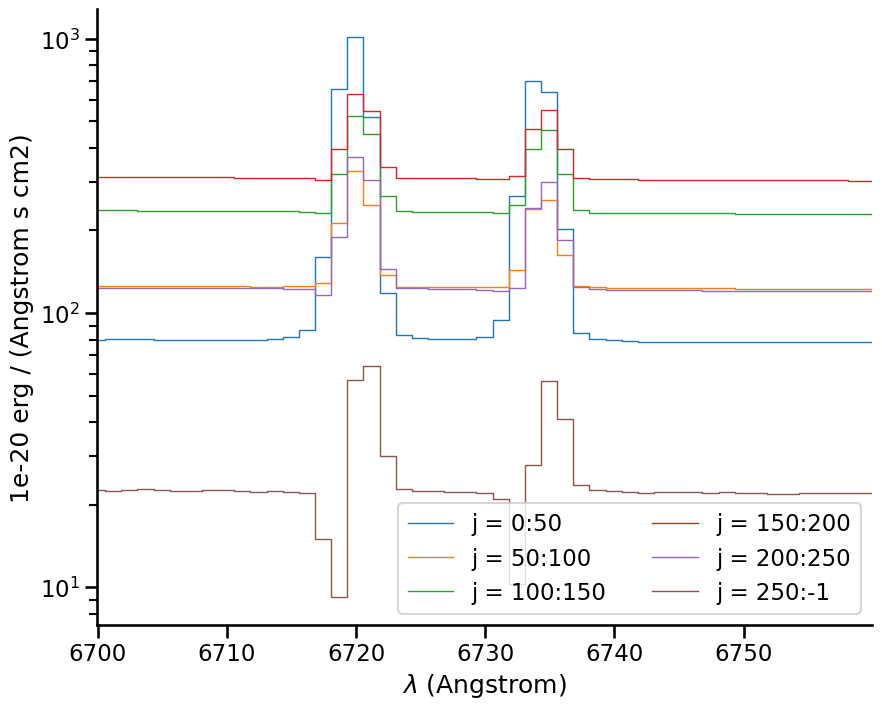

In [6]:
jstrips = [
    [0, 50],
    [50, 100],
    [100, 150],
    [150, 200],
    [200, 250],
    [250, -1],
]
wide_band = cube.select_lambda(6700, 6760)
fig, ax = plt.subplots(figsize=(10, 8))
for (j1, j2) in jstrips:
    (wide_band[:, j1:j2, :].mean(axis=(1, 2)).plot(label=f"j = {j1}:{j2}"))
ax.legend(ncol=2)
ax.set(yscale="log")
sns.despine()

In [7]:
wlim = {
    "6716": {
        "core": [6715.0, 6725.0],
        "blue": [6710.0, 6715.0],
        "red": [6725.0, 6730.0],
    },
    "6731": {
        "core": [6730.0, 6740.0],
        "blue": [6725.0, 6730.0],
        "red": [6740.0, 6745.0],
    },
}
rangecolors = {"core": "g", "blue": "b", "red": "r"}

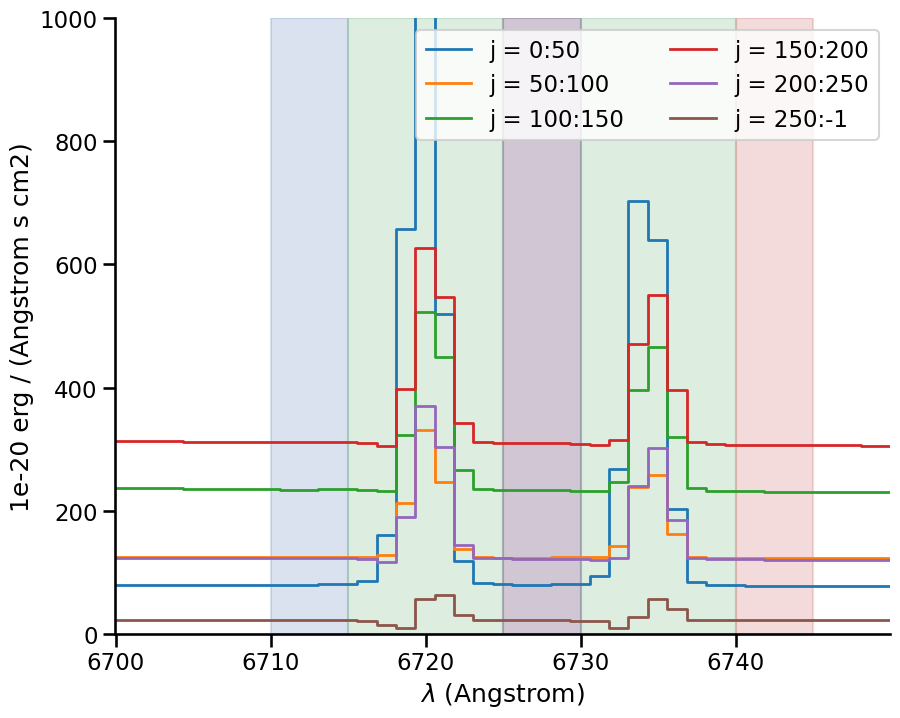

In [8]:
medium_band = cube.select_lambda(6700, 6750)
fig, ax = plt.subplots(figsize=(10, 8))
for (j1, j2) in jstrips:
    (
        medium_band[:, j1:j2, :]
        .mean(axis=(1, 2))
        .plot(label=f"j = {j1}:{j2}", linewidth=2)
    )

for line, linedata in wlim.items():
    for span, spandata in linedata.items():
        ax.axvspan(
            spandata[0], spandata[1], alpha=0.2, color=rangecolors[span], zorder=-100
        )
ax.legend(ncol=2)
ax.set(yscale="linear", ylim=[0.0, 1000])
sns.despine()

In [9]:
def extract_core_and_cont(cube, spandata):
    """Return continuum-subtracted line core and continuum map

    The line core is a 3D cube over the narrow core wavelengths
    """
    cblue = cube.select_lambda(*spandata["blue"]).mean(axis=0)
    cred = cube.select_lambda(*spandata["red"]).mean(axis=0)
    cont = 0.5 * (cblue + cred)
    core = cube.select_lambda(*spandata["core"]) - cont
    return core, cont

In [10]:
core6716, cont6716 = extract_core_and_cont(medium_band, wlim["6716"])
core6731, cont6731 = extract_core_and_cont(medium_band, wlim["6731"])

## Sort out sky correction

In [11]:
core6716.sum(axis=0).data.min()

-1519.1411865234359

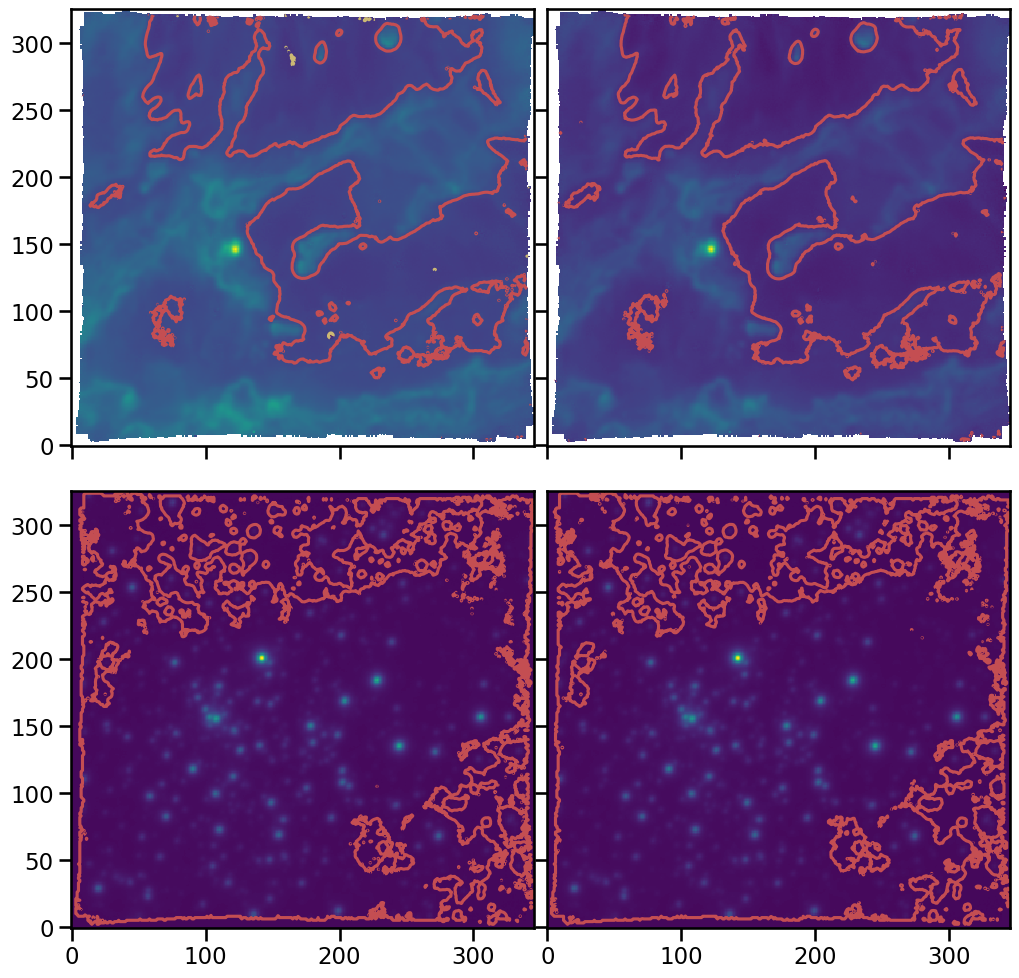

In [12]:
fig, axes = plt.subplots(
    2,
    2,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
)
core6716.sum(axis=0).plot(
    ax=axes[0, 0],
    scale="sqrt",
)
core6731.sum(axis=0).plot(
    ax=axes[0, 1],
    scale="sqrt",
)
cont6716.plot(ax=axes[1, 0], scale="sqrt")
cont6731.plot(ax=axes[1, 1], scale="sqrt")
axes[0, 0].contour(core6716.sum(axis=0).data, levels=[0.0], colors="r")
axes[0, 0].contour(
    core6716.sum(axis=0).data,
    levels=[-800.0],
    colors="y",
)
axes[0, 1].contour(core6731.sum(axis=0).data, levels=[0.0], colors="r")
axes[1, 0].contour(cont6716.data, levels=[0.0], colors="r")
axes[1, 1].contour(cont6731.data, levels=[0.0], colors="r")
fig.tight_layout(pad=0)

The distribution of negative pixels is different from with the high-ionization lines

In [13]:
np.where((core6716.sum(axis=0).data < -800.0) & (core6716.sum(axis=0).data > -850.0))

(array([141, 284, 285, 287, 288, 289, 289, 291, 294, 297, 317, 318, 318,
        319, 319, 321, 321]),
 array([340, 165, 165, 166, 165, 165, 166, 164, 162, 160, 219, 219, 226,
        219, 220, 159, 160]))

Looks like we found the fully negative part to subtract.  I will try out various rectangles for selecting the region:

In [14]:
skyoptions = {
    "minimalist": [slice(287, 289), slice(165, 166)],
    "wider": [slice(287, 289), slice(165, 167)],
    "taller": [slice(284, 290), slice(165, 167)],
}

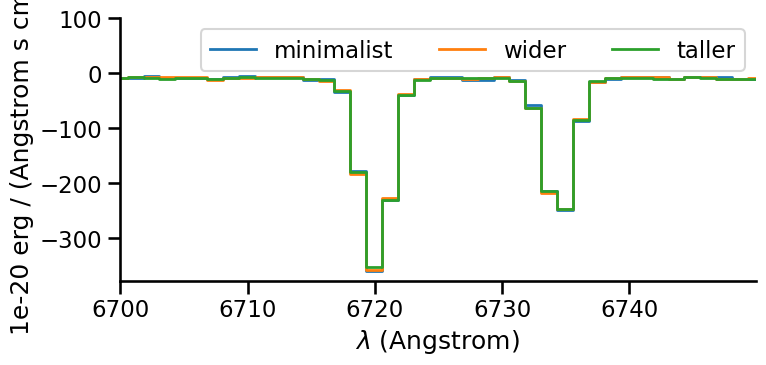

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
for label, (jslice, islice) in skyoptions.items():
    skyspec_medium = medium_band[:, jslice, islice].mean(axis=(1, 2))
    skyspec_medium.plot(label=label, linewidth=2)
ax.legend(ncol=3)
ax.set(ylim=[None, 100])
fig.tight_layout()
sns.despine()

The three options look almost identical, but amazingly it does make a difference.  I originally used "minimalist", which worked fine for 6716, but caused velocities to go very red at low brightnesses for 6731.  I have now switched to "taller", which seems to work better.

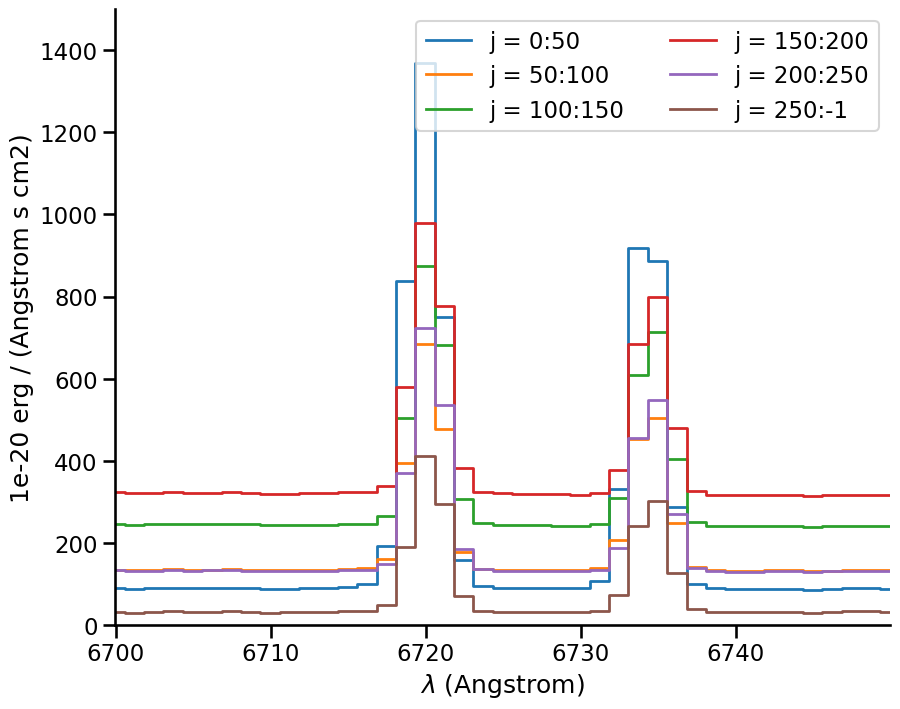

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
jslice, islice = skyoptions["taller"]
skyspec_medium = medium_band[:, jslice, islice].mean(axis=(1, 2))
for (j1, j2) in jstrips:
    (
        (medium_band - skyspec_medium)[:, j1:j2, :]
        .mean(axis=(1, 2))
        .plot(label=f"j = {j1}:{j2}", linewidth=2)
    )

ax.legend(ncol=2)
ax.set(yscale="linear", ylim=[0.0, 1500])
sns.despine()

In [17]:
jslice, islice = skyoptions["taller"]
skyspec6716 = core6716[:, jslice, islice].mean(axis=(1, 2))
skyspec6731 = core6731[:, jslice, islice].mean(axis=(1, 2))

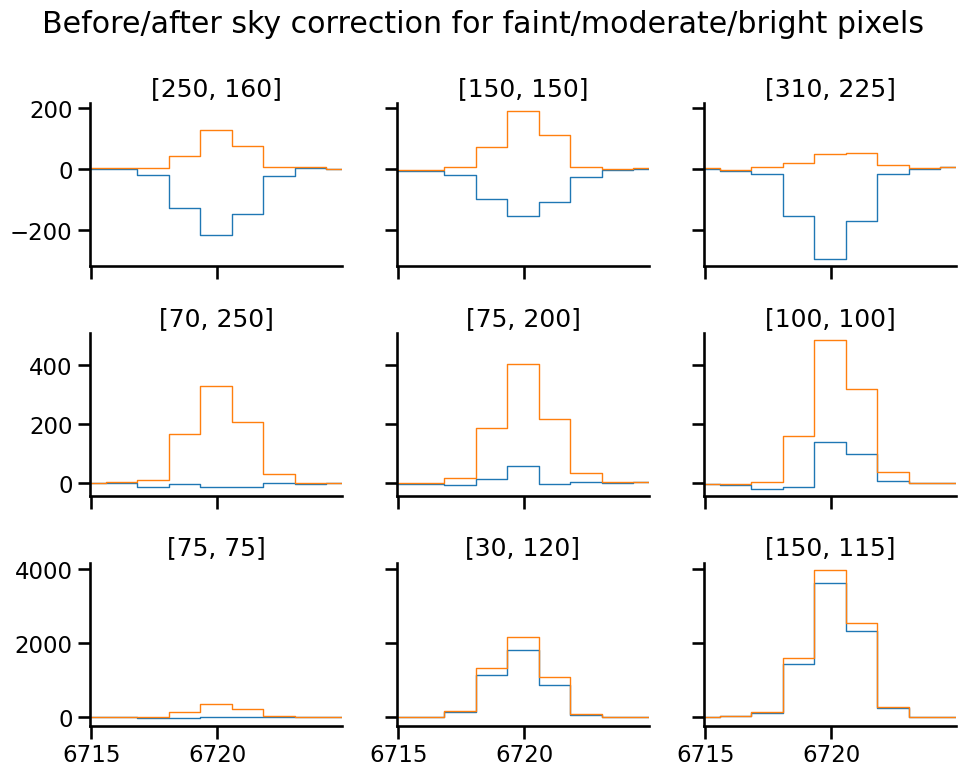

In [18]:
testpixels = [
    [250, 160],
    [150, 150],
    [310, 225],
    [70, 250],
    [75, 200],
    [100, 100],
    [75, 75],
    [30, 120],
    [150, 115],  # [180, 290],
]
fig, axes = plt.subplots(
    3,
    3,
    figsize=(10, 8),
    sharex=True,
    sharey="row",
)
for (j, i), ax in zip(testpixels, axes.flat):
    core6716[:, j, i].plot(ax=ax)
    (core6716[:, j, i] - skyspec6716).plot(ax=ax)
    ax.set(xlabel="", ylabel="")
    ax.set_title(f"[{j}, {i}]")
fig.suptitle("Before/after sky correction for faint/moderate/bright pixels")
sns.despine()
fig.tight_layout()

Repeat for the 6731 component

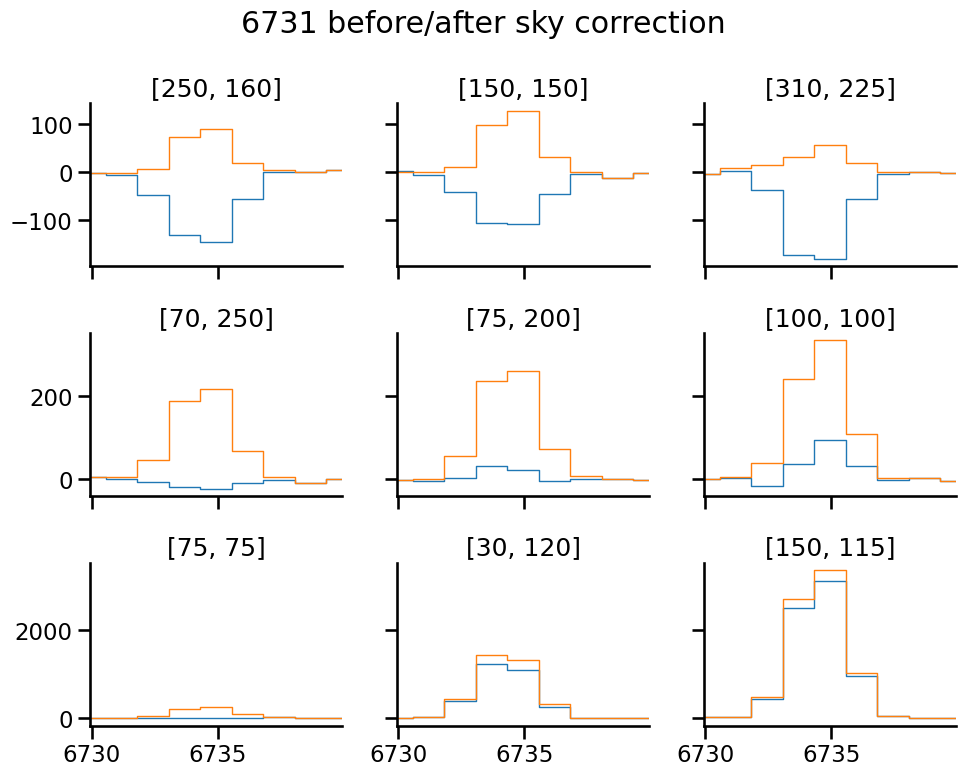

In [19]:
fig, axes = plt.subplots(
    3,
    3,
    figsize=(10, 8),
    sharex=True,
    sharey="row",
)
for (j, i), ax in zip(testpixels, axes.flat):
    core6731[:, j, i].plot(ax=ax)
    (core6731[:, j, i] - skyspec6731).plot(ax=ax)
    ax.set(xlabel="", ylabel="")
    ax.set_title(f"[{j}, {i}]")
fig.suptitle(
    "6731 before/after sky correction",
)
sns.despine()
fig.tight_layout()

/Users/will/Dropbox/muse-hii-regions/.venv/lib/python3.14/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
/Users/will/Dropbox/muse-hii-regions/.venv/lib/python3.14/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


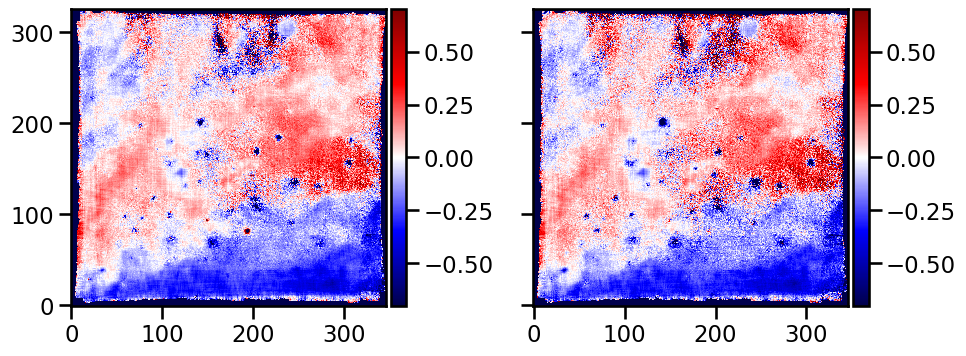

In [20]:
mom6716 = moments.find_moments(core6716 - skyspec6716)
mom6731 = moments.find_moments(core6731 - skyspec6731)
wav6716 = np.median(mom6716[1].data.data)
wav6731 = np.median(mom6731[1].data.data)
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    sharey=True,
)
(mom6716[1] - wav6716).plot(
    cmap="seismic",
    vmin=-0.7,
    vmax=+0.7,
    colorbar="v",
    ax=axes[0],
)
(mom6731[1] - wav6731).plot(
    cmap="seismic",
    vmin=-0.7,
    vmax=+0.7,
    colorbar="v",
    ax=axes[1],
)
fig.tight_layout()

These look great!

~The only disagreement is in the low-intensity regions where the sky correction may need finessing.~ This is now fixed

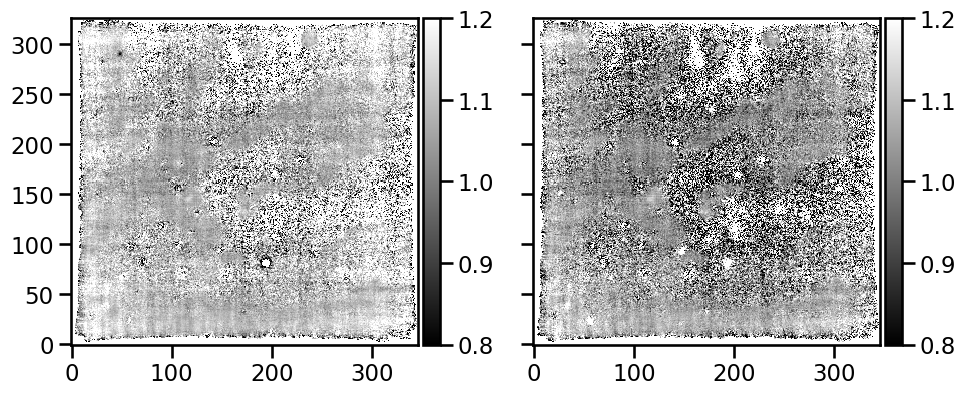

In [21]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    sharey=True,
)
mom6716[2].plot(
    cmap="gray",
    vmin=0.8,
    vmax=1.2,
    colorbar="v",
    ax=axes[0],
)
mom6731[2].plot(
    cmap="gray",
    vmin=0.8,
    vmax=1.2,
    colorbar="v",
    ax=axes[1],
)
fig.tight_layout()

In [22]:
mom_pars_6716 = dict(
    restwav=6716.44,
    irange=[10, 4.0e4],
    vrange=[135, 195],
    srange=[30, 70],
)
moments.save_moments_to_fits(
    mom6716,
    label="6716",
    flabel="ngc346-sii",
    restwav=6716.44,
)
moments.save_moments_to_fits(
    mom6731,
    label="6731",
    flabel="ngc346-sii",
    restwav=6730.816,
)

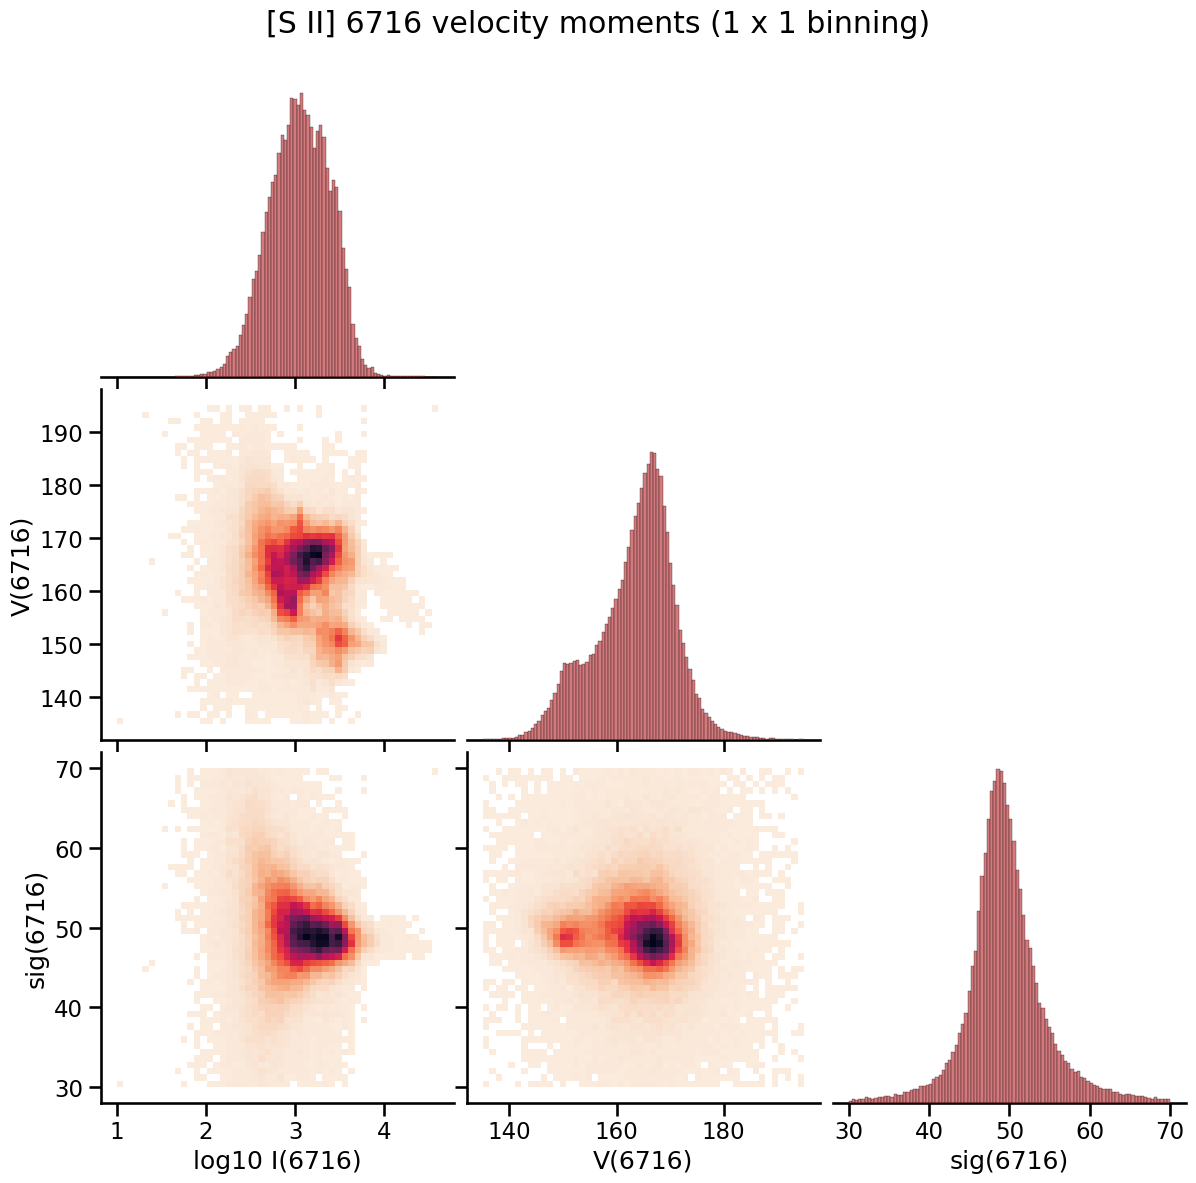

In [23]:
plot_pars_6716 = dict(
    ilabel="[S II]",
    label="6716",
    flabel="ngc346-sii",
    **mom_pars_6716,
)
g = moments.moments_corner_plot(mom6716, rebin=1, **plot_pars_6716)

This shows some interesting structure in the I-V distribution. We see the same two velocity components of [O III] (158 and 164), plus an additional one at 150 (which is very weak in [O III])

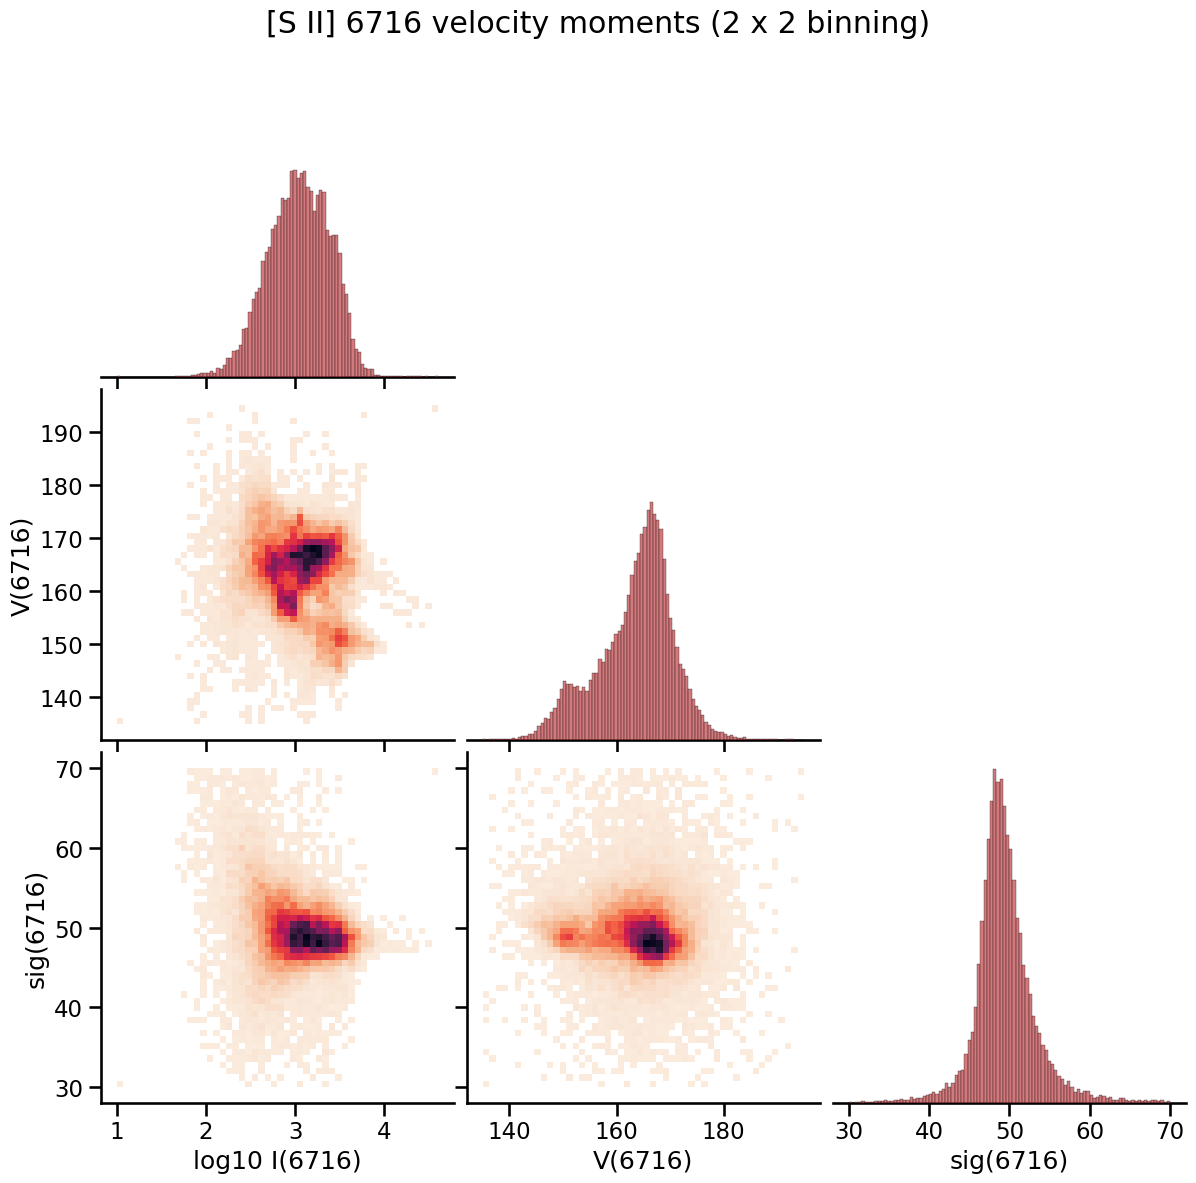

In [24]:
g = moments.moments_corner_plot(mom6716, rebin=2, **plot_pars_6716)

Rebinning doesn't help as much as I had hoped.  But it does reduce the spread in the sigma for the lower intensities.

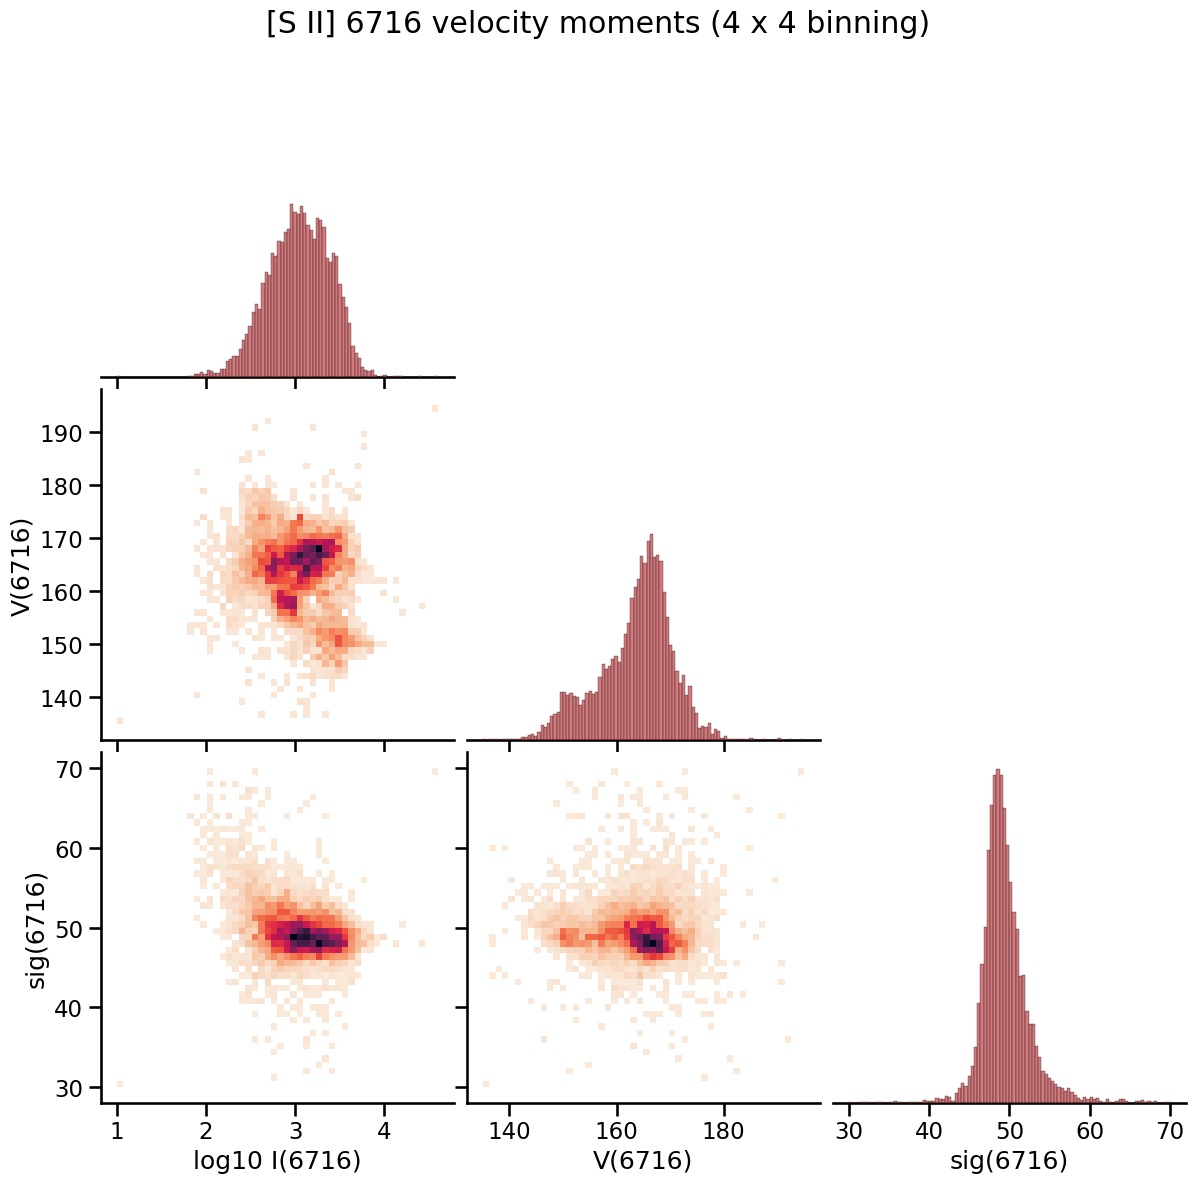

In [25]:
g = moments.moments_corner_plot(mom6716, rebin=4, **plot_pars_6716)

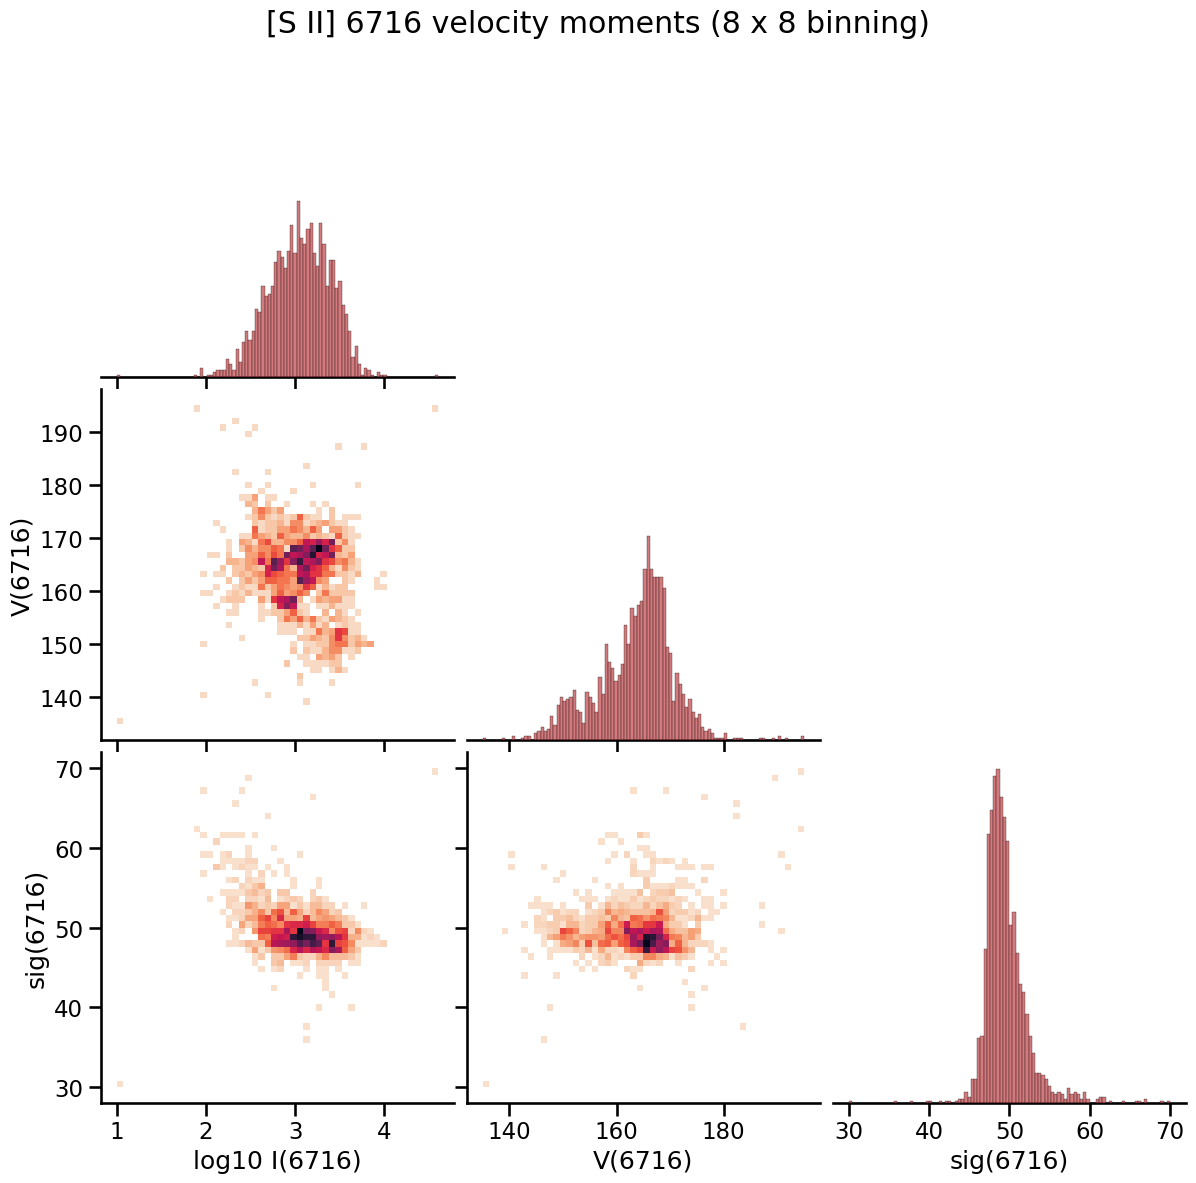

In [26]:
g = moments.moments_corner_plot(mom6716, rebin=8, **plot_pars_6716)

As we increase the binning, the sig distribution becomes narrower, but the V and I remain almost unchanged.  This is a sign that th scale of significant variations is large (steep spatial power law)

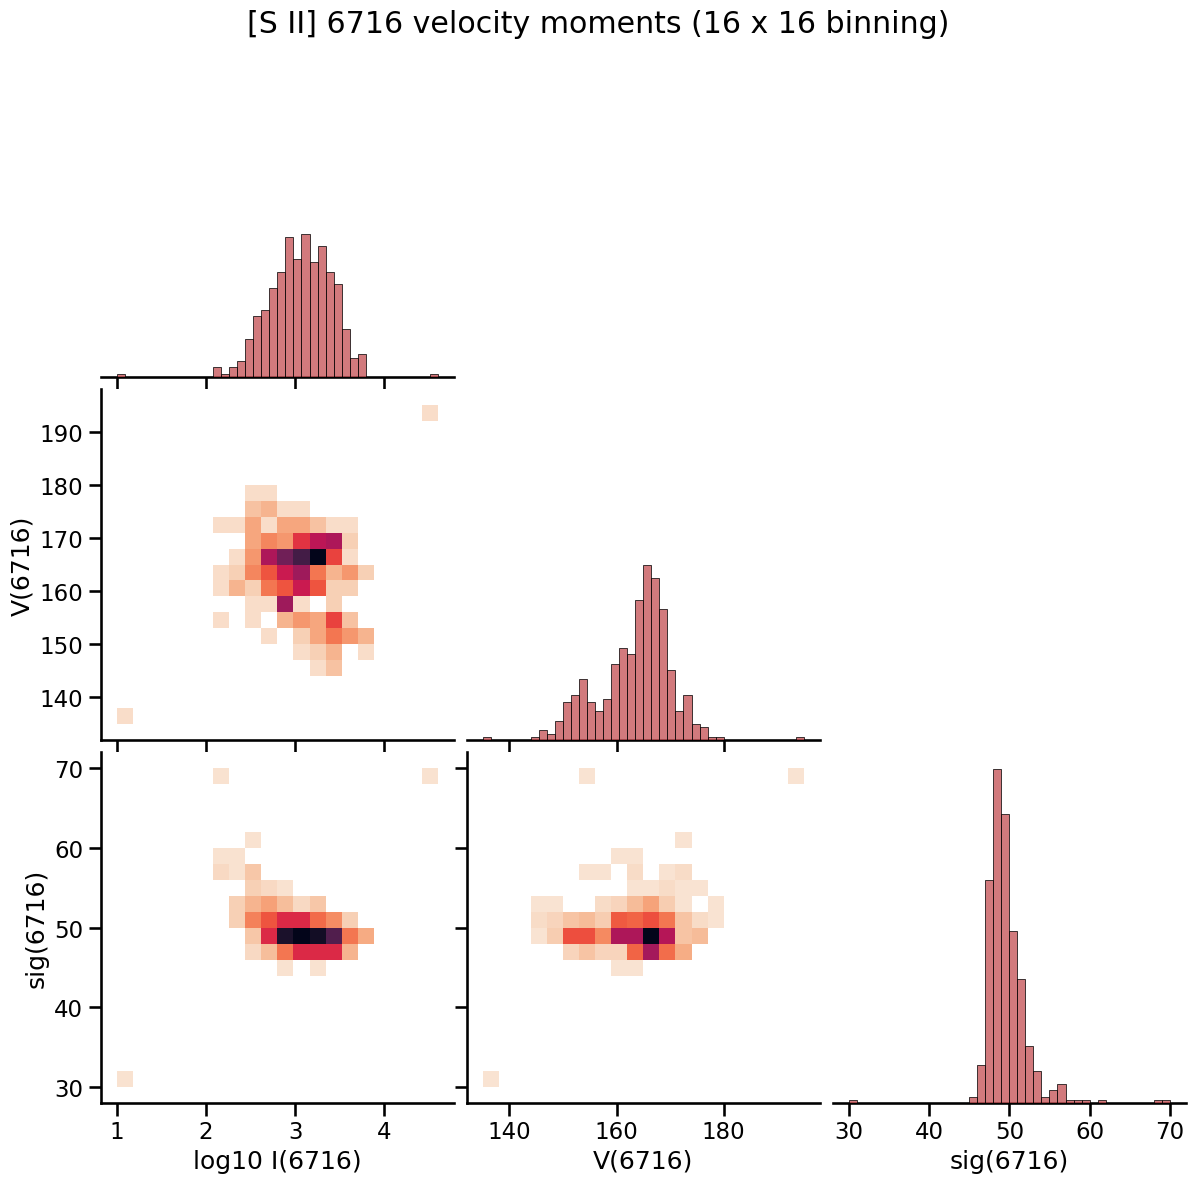

In [27]:
g = moments.moments_corner_plot(
    mom6716,
    rebin=16,
    **plot_pars_6716,
    hist_bins=40,
    image_bins=20,
)

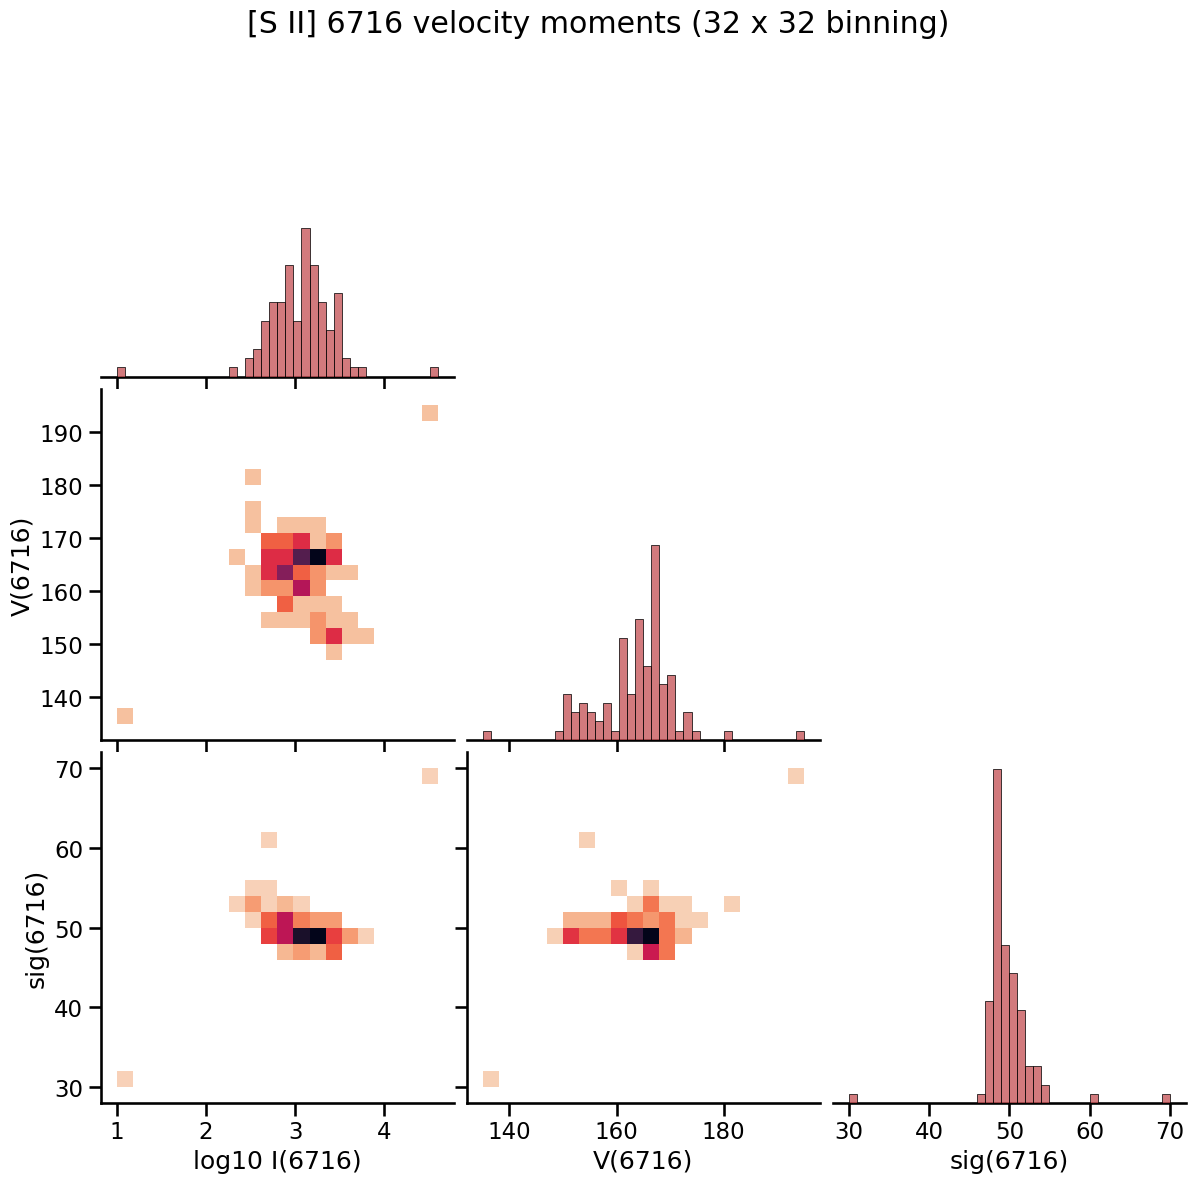

In [28]:
g = moments.moments_corner_plot(
    mom6716,
    rebin=32,
    **plot_pars_6716,
    hist_bins=40,
    image_bins=20,
)

In [29]:
mom0 = mom6731[0].rebin(2)
mom1 = mom6731[1].rebin(2)
mom2 = mom6731[2].rebin(2)
rest6731 = 6730.816
m = (
    mom0.mask
    | (mom0.data < 40)
    | (mom1.data < wav6731 - 0.6)
    | (mom1.data > wav6731 + 0.6)
    | (mom2.data < 0.8)
    | (mom2.data > 1.5)
)
df = pd.DataFrame(
    {
        "log10 I(6731)": np.log10(mom0.data[~m]),
        "V(6731)": 3e5 * (mom1.data[~m] - rest6731) / rest6731,
        "sig(6731)": 3e5 * mom2.data[~m] / rest6731,
    }
)
df.describe()

,log10 I(6731),V(6731),sig(6731)
count,24852.000000,24852.000000,24852.000000
mean,2.919212,164.538241,46.480054
std,0.339801,7.554370,4.153869
min,1.612606,138.235797,35.657735
25%,2.689857,160.391228,44.220760
50%,2.924718,165.733362,46.518647
75%,3.168931,169.291908,48.648257
max,4.606800,191.327818,66.855778


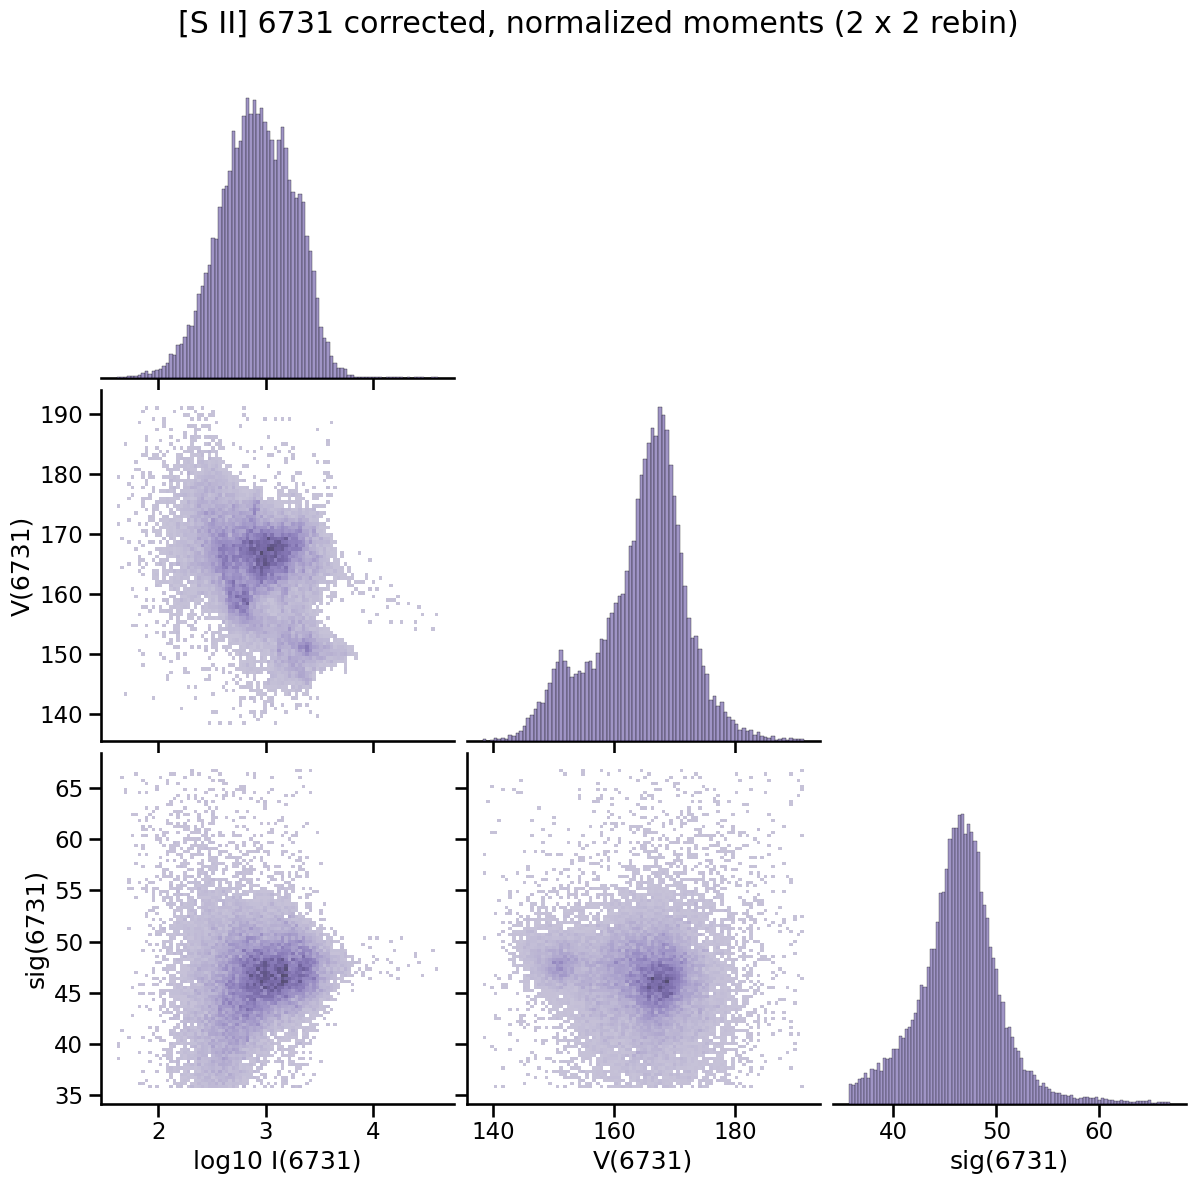

In [30]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="m"),
    diag_kws=dict(color="m"),
)
g.fig.suptitle("[S II] 6731 corrected, normalized moments (2 x 2 rebin)")
g.tight_layout(pad=0)

,log10 I(6731),V(6731),sig(6731)
count,1679.000000,1679.000000,1679.000000
mean,2.909416,164.584752,46.147963
std,0.345992,7.294860,3.020875
min,1.760111,140.598028,35.910292
25%,2.672049,160.629027,44.351803
50%,2.918229,165.861851,46.080703
75%,3.165400,169.091678,47.765430
max,4.076453,190.397166,66.460873


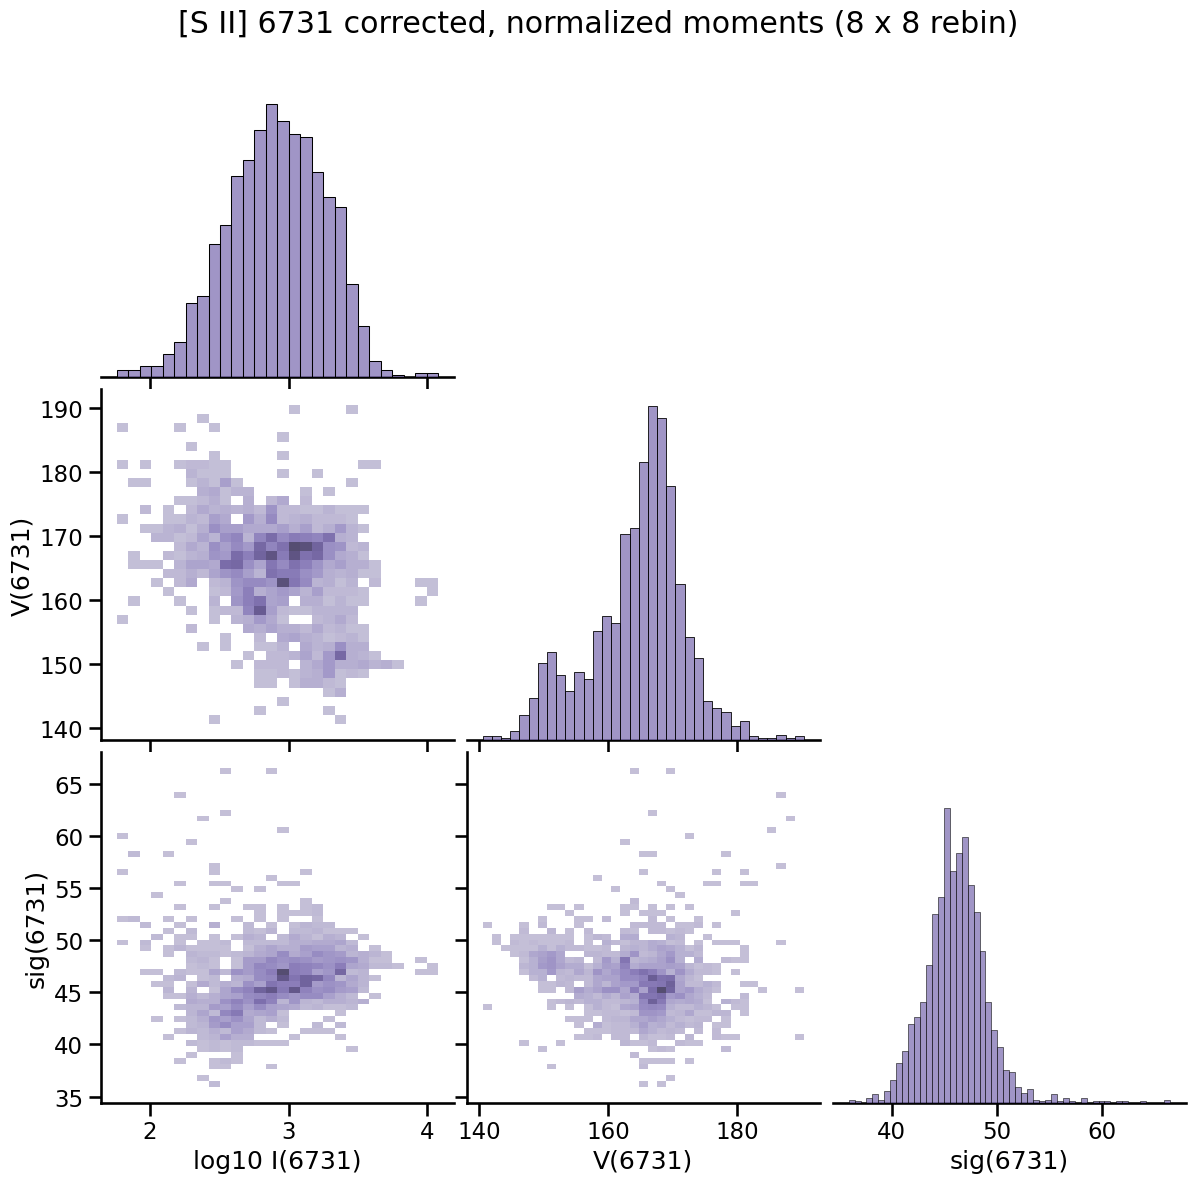

In [31]:
mom0 = mom6731[0].rebin(8)
mom1 = mom6731[1].rebin(8)
mom2 = mom6731[2].rebin(8)
rest6731 = 6730.816
m = (
    mom0.mask
    | (mom0.data < 40)
    | (mom1.data < wav6731 - 0.6)
    | (mom1.data > wav6731 + 0.6)
    | (mom2.data < 0.8)
    | (mom2.data > 1.5)
)
df = pd.DataFrame(
    {
        "log10 I(6731)": np.log10(mom0.data[~m]),
        "V(6731)": 3e5 * (mom1.data[~m] - rest6731) / rest6731,
        "sig(6731)": 3e5 * mom2.data[~m] / rest6731,
    }
)

g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="m"),
    diag_kws=dict(color="m"),
)
g.fig.suptitle("[S II] 6731 corrected, normalized moments (8 x 8 rebin)")
g.tight_layout(pad=0)
df.describe()

An aggressive rebinning of 8x8 tightens up the dispersion of the sigma to 46 +/- 3, but this is not so much as with the 6716 component (49 +/- 2.4), although probably not significant.

More importantly, the upturn in V(6731) at low intensity ~does not go away~ (**this is hardly noticeable now**), meaning that it is certainly due to systematic error in the zero point (it is not seen at all in V(6716).  **This is now largely fixed. The tail for V(6731) > 180 has been almost completely eliminated.**

I fixed this by using a slightly different rectangle for estimating the bad sky: see `skyoptions["taller"]` above.

In [32]:
rest6716 = 6716.44

mom0_A = mom6716[0]
mom1_A = mom6716[1]
mom2_A = mom6716[2]
mom0_B = mom6731[0]
mom1_B = mom6731[1]
mom2_B = mom6731[2]

wav_A = wav6716
wav_B = wav6731
rest_A = rest6716
rest_B = rest6731

label_A = "6716"
label_B = "6731"

m = (
    mom0_A.mask
    | (mom0_A.data < 60)
    | (mom1_A.data < wav6716 - 0.6)
    | (mom1_A.data > wav6716 + 0.6)
    | (mom2_A.data < 0.8)
    | (mom2_A.data > 1.5)
    | mom0_B.mask
    | (mom0_B.data < 40)
    | (mom1_B.data < wav6731 - 0.6)
    | (mom1_B.data > wav6731 + 0.6)
    | (mom2_B.data < 0.8)
    | (mom2_B.data > 1.5)
)
df2 = pd.DataFrame(
    {
        f"log10 I({label_A})": np.log10(mom0_A.data[~m]),
        f"V({label_A})": 3e5 * (mom1_A.data[~m] - rest_A) / rest_A,
        f"sig({label_A})": 3e5 * mom2_A.data[~m] / rest_A,
        f"log10 I({label_B})": np.log10(mom0_B.data[~m]),
        f"V({label_B})": 3e5 * (mom1_B.data[~m] - rest_B) / rest_B,
        f"sig({label_B})": 3e5 * mom2_B.data[~m] / rest_B,
    }
)
df2.corr()

,log10 I(6716),V(6716),sig(6716),log10 I(6731),V(6731),sig(6731)
log10 I(6716),1.000000,-0.237424,-0.187609,0.997607,-0.341386,-0.048908
V(6716),-0.237424,1.000000,-0.068777,-0.236483,0.828362,-0.118938
sig(6716),-0.187609,-0.068777,1.000000,-0.199363,0.036914,0.165786
log10 I(6731),0.997607,-0.236483,-0.199363,1.000000,-0.339270,-0.029239
V(6731),-0.341386,0.828362,0.036914,-0.339270,1.000000,0.016949
sig(6731),-0.048908,-0.118938,0.165786,-0.029239,0.016949,1.000000


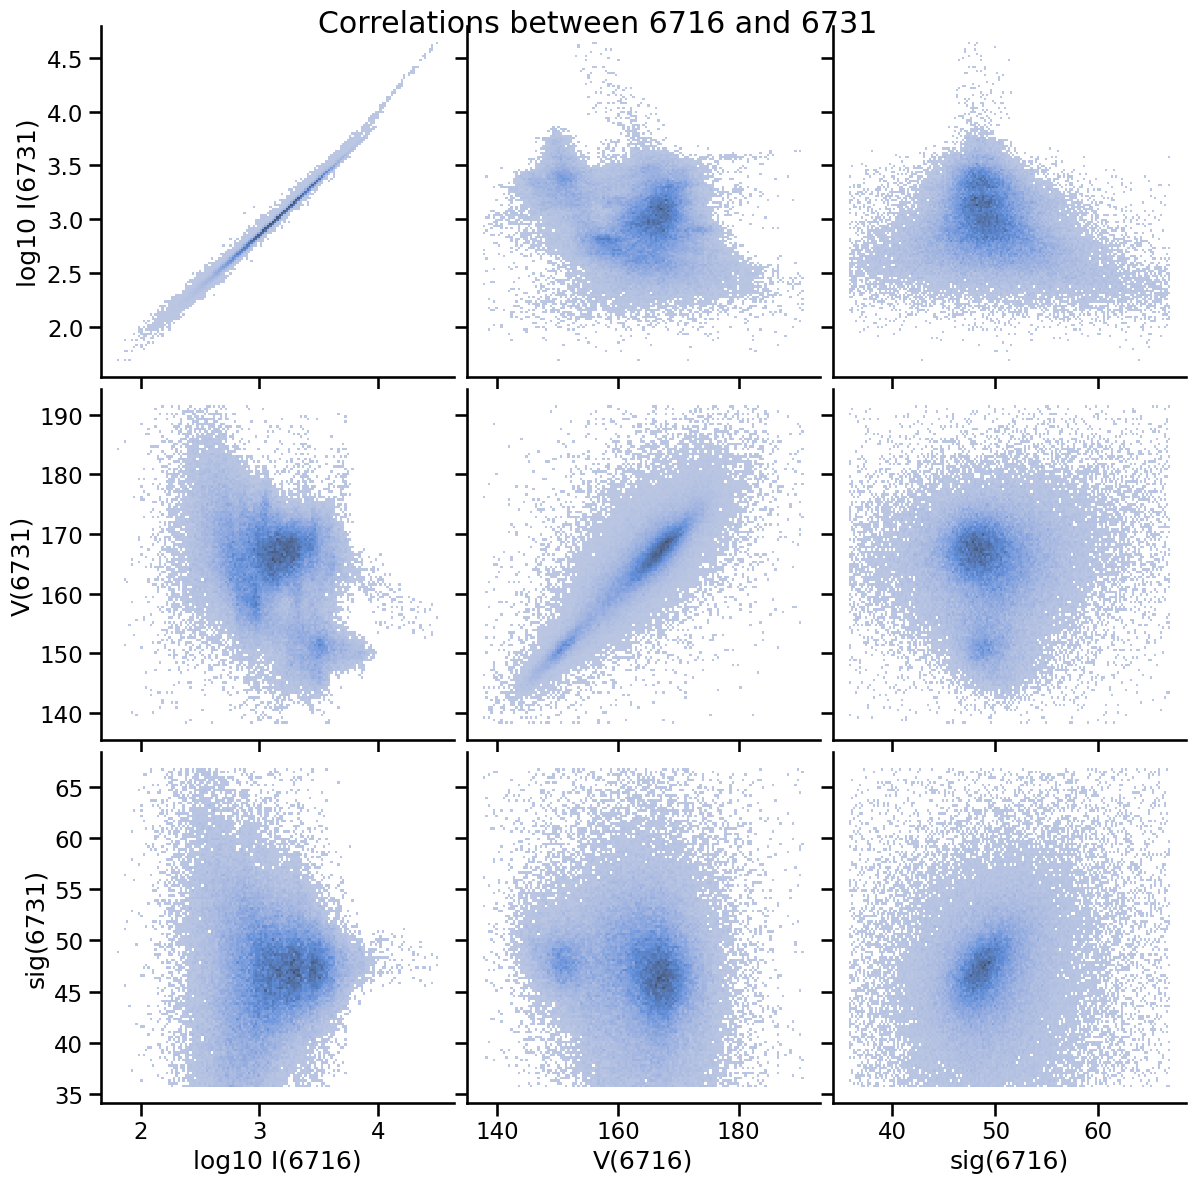

In [33]:
xvars = [_ for _ in df2.columns if label_A in _]
yvars = [_ for _ in df2.columns if label_B in _]

g = sns.pairplot(
    df2,
    kind="hist",
    height=4,
    x_vars=xvars,
    y_vars=yvars,
    plot_kws=dict(color="b"),
)
g.fig.suptitle("Correlations between 6716 and 6731")
g.tight_layout(pad=0)

In [34]:
df3 = df2[["log10 I(6716)"]].copy()
df3["6716 / 6731"] = 10 ** (df2["log10 I(6716)"] - df2["log10 I(6731)"])
df3["dV"] = df2["V(6716)"] - df2["V(6731)"]
df3["sig ratio"] = df2["sig(6716)"] / df2["sig(6731)"]
df3.describe()

,log10 I(6716),6716 / 6731,dV,sig ratio
count,89512.000000,89512.000000,89512.000000,89512.000000
mean,3.100046,1.381402,-1.042723,1.059489
std,0.310163,0.067264,4.438434,0.131829
min,1.799525,0.663110,-48.936463,0.548078
25%,2.884707,1.353097,-2.636782,0.987230
50%,3.102695,1.384880,-0.593412,1.043248
75%,3.328486,1.415738,1.018039,1.119355
max,4.507598,2.108843,42.472300,1.865886


In [35]:
m = (
    (df3["6716 / 6731"] < 0.6)
    | (df3["6716 / 6731"] > 1.6)
    | (np.abs(df3["dV"]) > 15.0)
    | (df3["sig ratio"] < 0.3)
    | (df3["sig ratio"] > 1.7)
)

df3 = df3[~m]
df3.corr()

,log10 I(6716),6716 / 6731,dV,sig ratio
log10 I(6716),1.000000,-0.170664,0.176854,-0.132198
6716 / 6731,-0.170664,1.000000,-0.014184,0.380780
dV,0.176854,-0.014184,1.000000,0.072714
sig ratio,-0.132198,0.380780,0.072714,1.000000


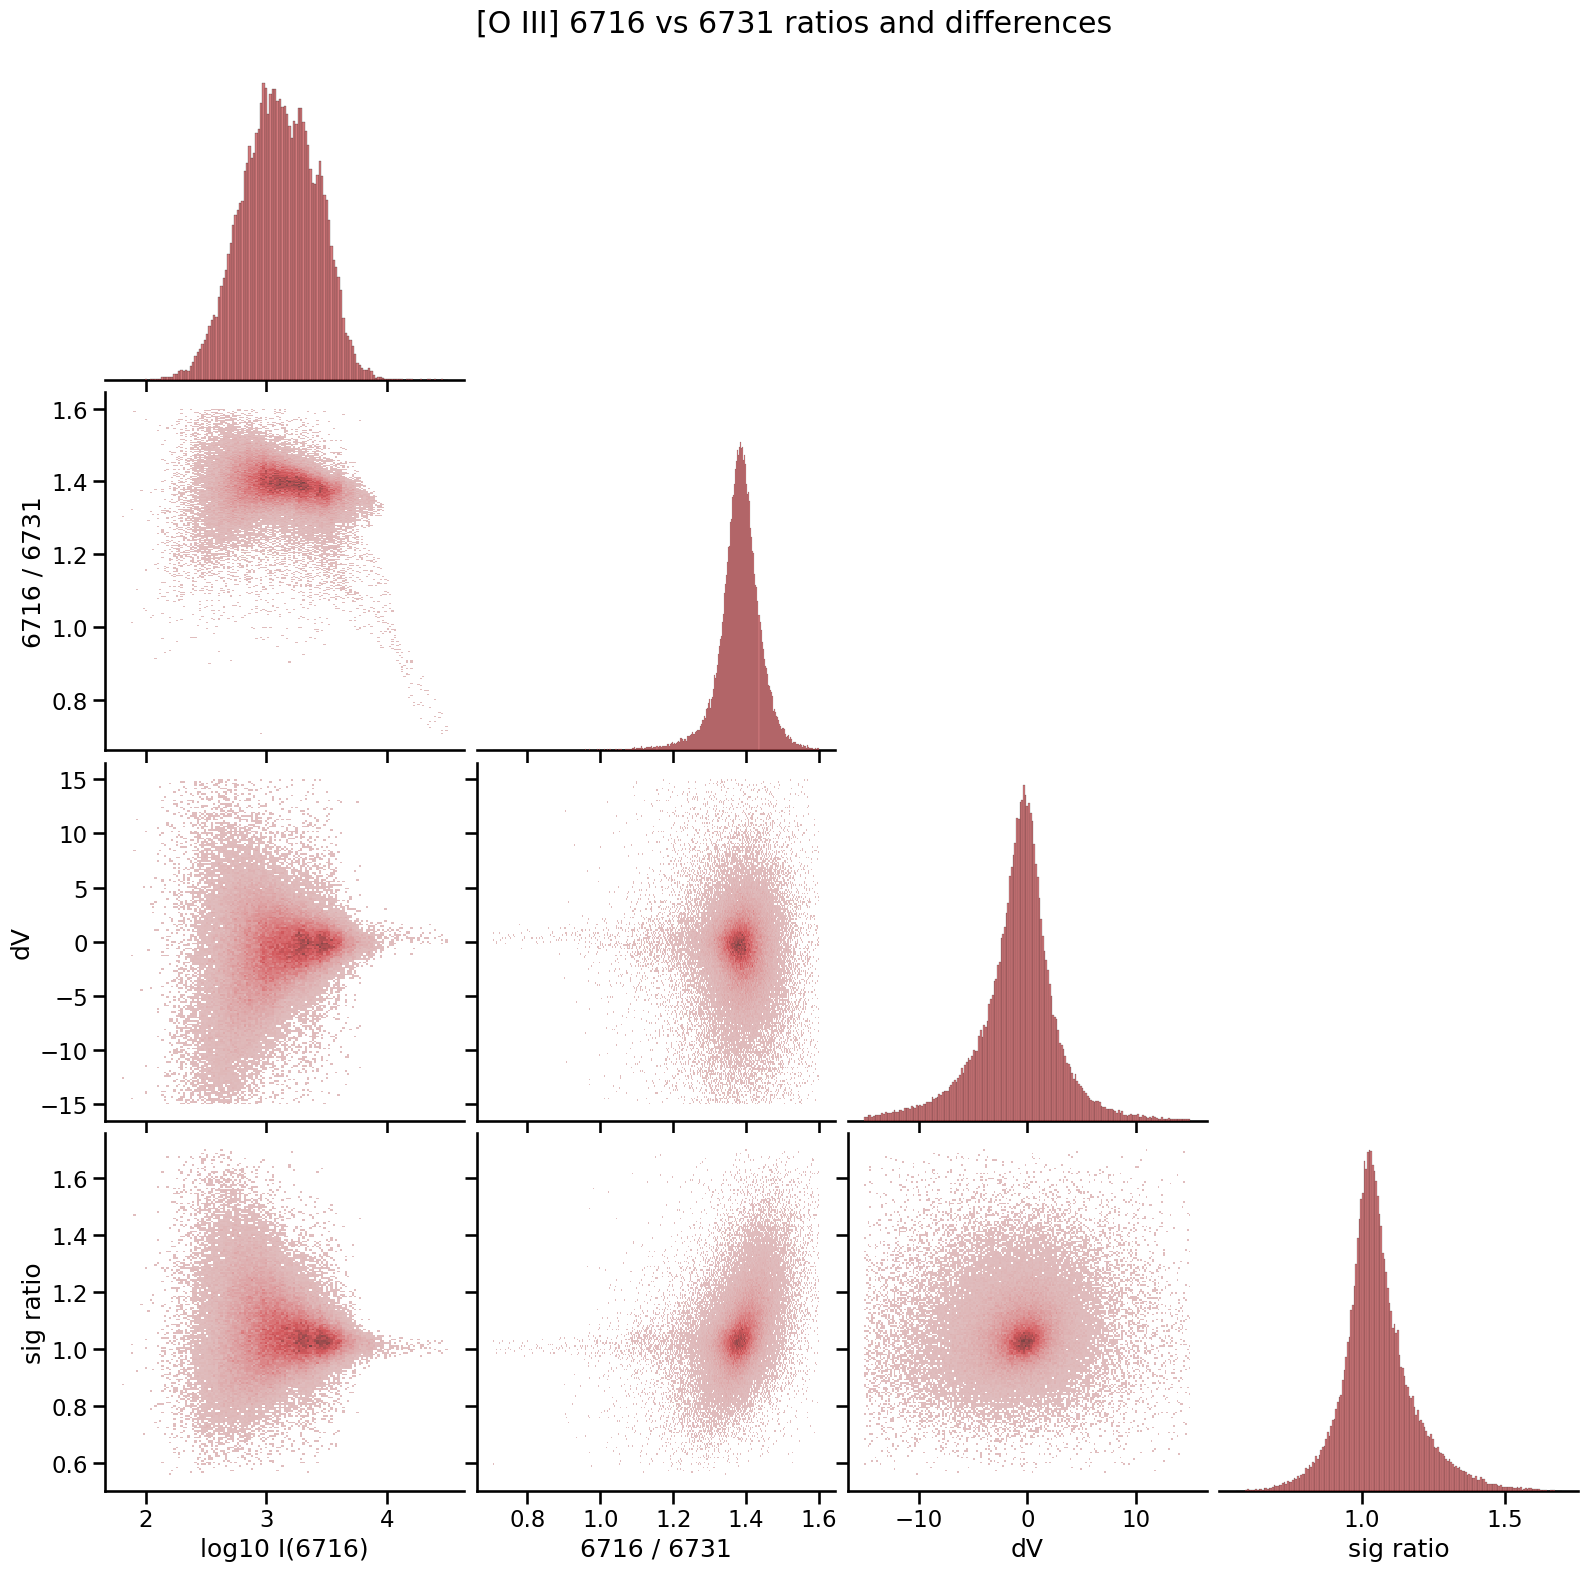

In [36]:
g = sns.pairplot(
    df3,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="r"),
    diag_kws=dict(color="r"),
)
g.fig.suptitle("[O III] 6716 vs 6731 ratios and differences")
g.tight_layout(pad=0)

We see that for the faint pixels, there is a large spread in R, dV and sig ratio, which is entirely due to noise.

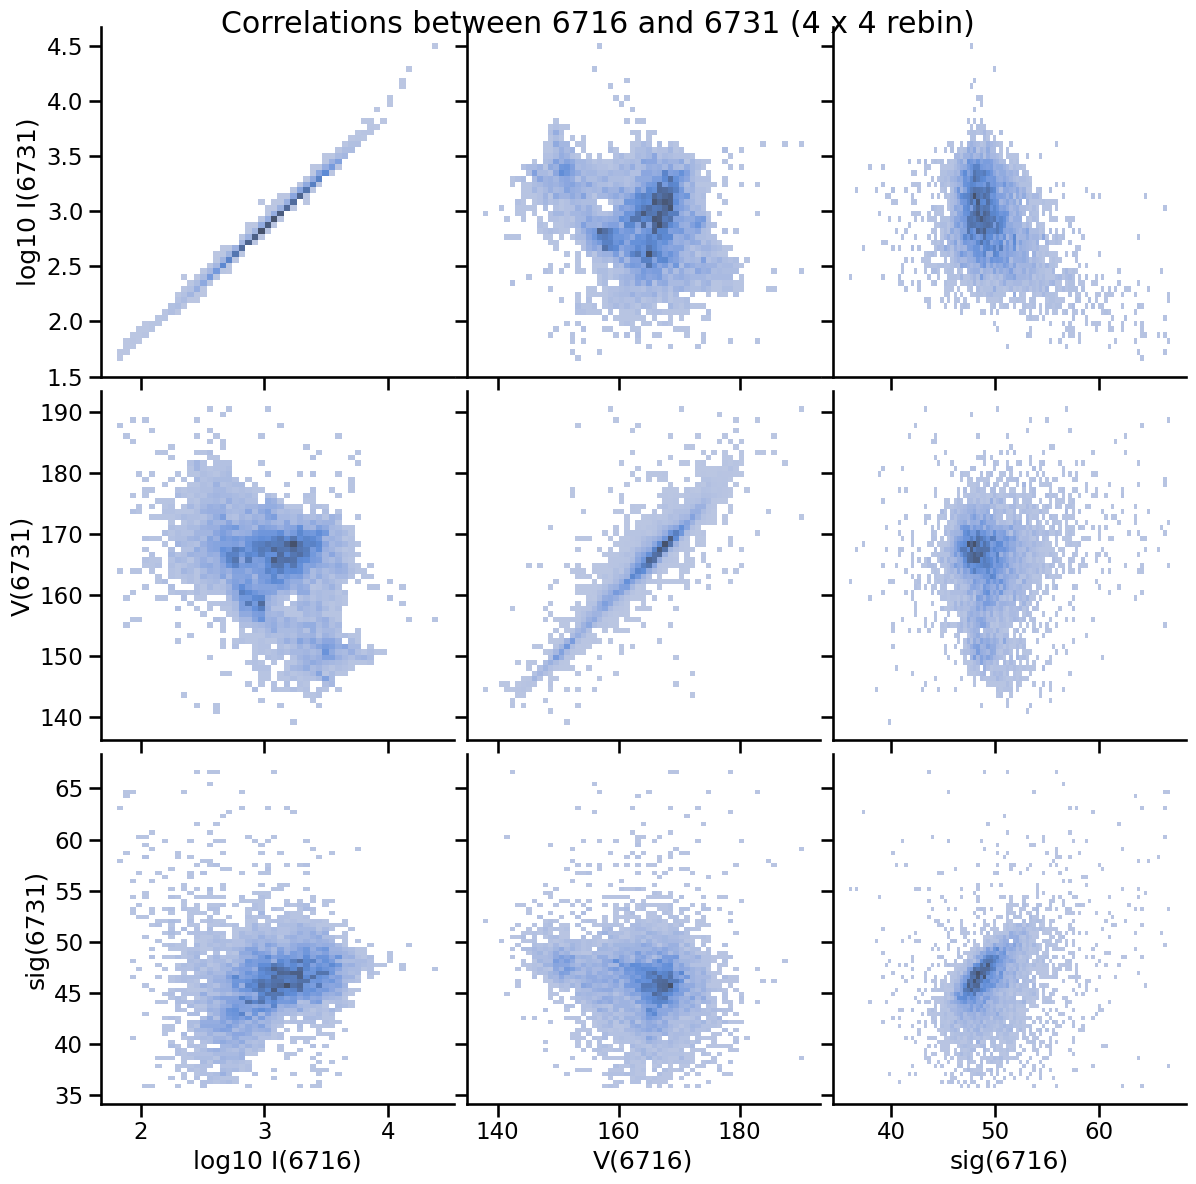

In [37]:
N = 4
mom0_A = mom6716[0].rebin(N)
mom1_A = mom6716[1].rebin(N)
mom2_A = mom6716[2].rebin(N)
mom0_B = mom6731[0].rebin(N)
mom1_B = mom6731[1].rebin(N)
mom2_B = mom6731[2].rebin(N)

m = (
    mom0_A.mask
    | (mom0_A.data < 60)
    | (mom1_A.data < wav6716 - 0.6)
    | (mom1_A.data > wav6716 + 0.6)
    | (mom2_A.data < 0.8)
    | (mom2_A.data > 1.5)
    | mom0_B.mask
    | (mom0_B.data < 40)
    | (mom1_B.data < wav6731 - 0.6)
    | (mom1_B.data > wav6731 + 0.6)
    | (mom2_B.data < 0.8)
    | (mom2_B.data > 1.5)
)
df2 = pd.DataFrame(
    {
        f"log10 I({label_A})": np.log10(mom0_A.data[~m]),
        f"V({label_A})": 3e5 * (mom1_A.data[~m] - rest_A) / rest_A,
        f"sig({label_A})": 3e5 * mom2_A.data[~m] / rest_A,
        f"log10 I({label_B})": np.log10(mom0_B.data[~m]),
        f"V({label_B})": 3e5 * (mom1_B.data[~m] - rest_B) / rest_B,
        f"sig({label_B})": 3e5 * mom2_B.data[~m] / rest_B,
    }
)

xvars = [_ for _ in df2.columns if label_A in _]
yvars = [_ for _ in df2.columns if label_B in _]

g = sns.pairplot(
    df2,
    kind="hist",
    height=4,
    x_vars=xvars,
    y_vars=yvars,
    plot_kws=dict(color="b"),
)
g.fig.suptitle(f"Correlations between {label_A} and {label_B}" + f" ({N} x {N} rebin)")
g.tight_layout(pad=0)

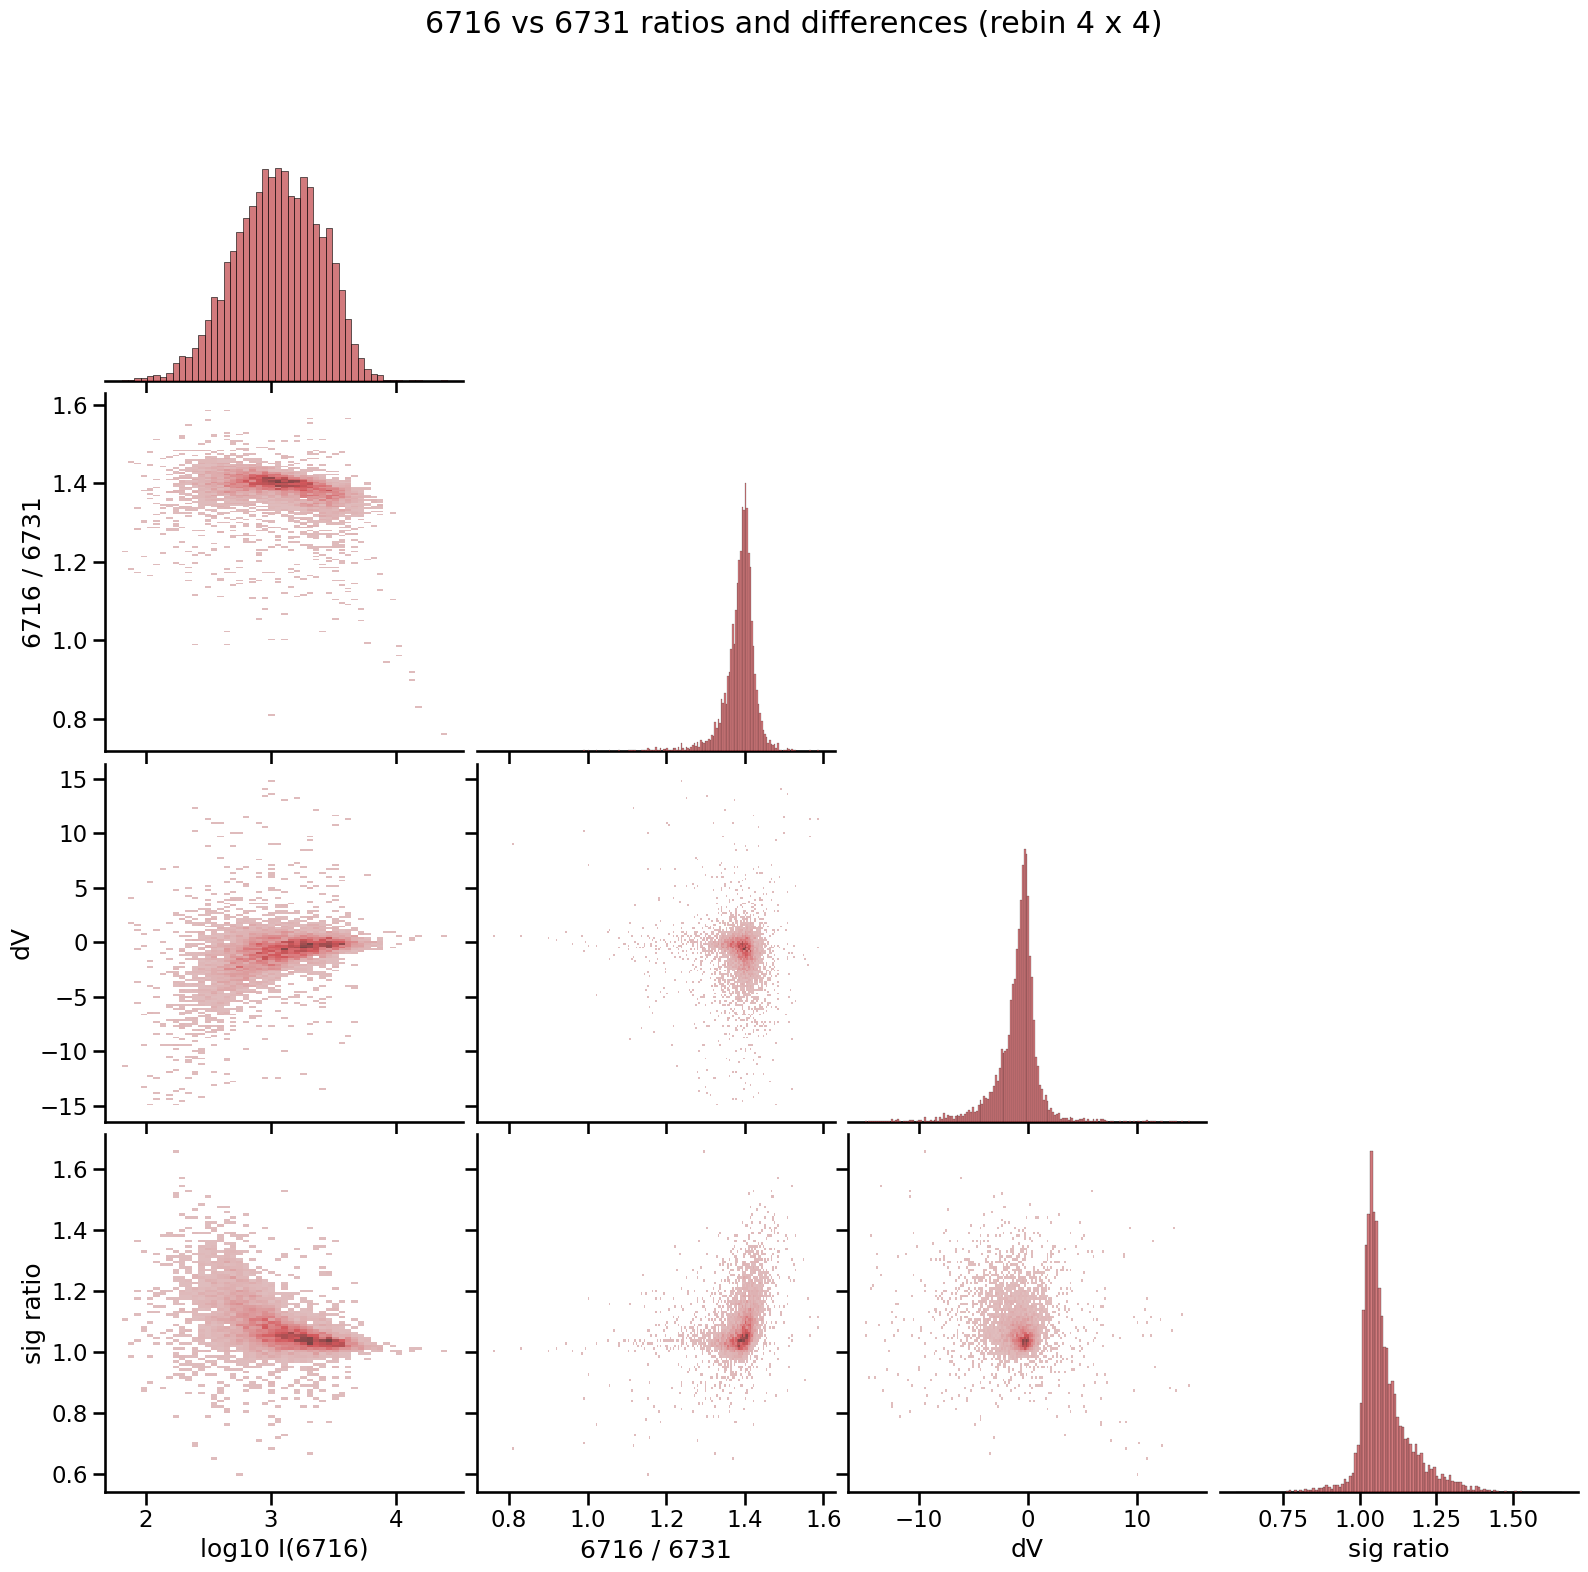

In [38]:
df3 = df2[["log10 I(6716)"]].copy()
df3["6716 / 6731"] = 10 ** (df2["log10 I(6716)"] - df2["log10 I(6731)"])
df3["dV"] = df2["V(6716)"] - df2["V(6731)"]
df3["sig ratio"] = df2["sig(6716)"] / df2["sig(6731)"]
m = (
    (df3["6716 / 6731"] < 0.6)
    | (df3["6716 / 6731"] > 1.6)
    | (np.abs(df3["dV"]) > 15.0)
    | (df3["sig ratio"] < 0.3)
    | (df3["sig ratio"] > 1.7)
)
df3 = df3[~m]
g = sns.pairplot(
    df3,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="r"),
    diag_kws=dict(color="r"),
)
g.fig.suptitle(f"{label_A} vs {label_B} ratios and differences" + f" (rebin {N} x {N})")
g.tight_layout(pad=0)

By binning at 4x4 we can see that we do still have a small problem at low brightnesses: dV starts bending negative and sig_ratio increases.  This is almost certainly due to residual sky errors, but it isn't very important.

The same thing is probably causing the apparent correlation between sig ratio and R(6716/6731).